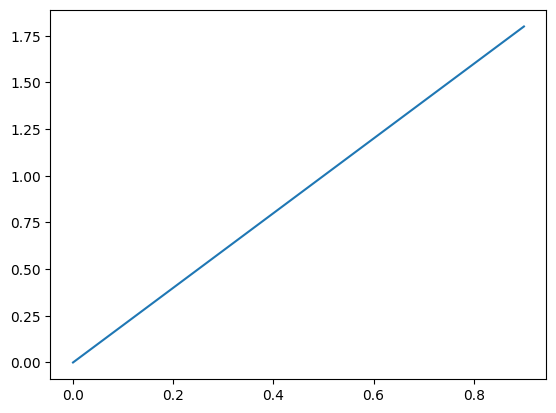

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
from scipy.stats import norm
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import torch.nn.functional as F
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [13]:
epochs = 100
rTrain = 0.7;
rTest = 0.2;
rValidation = 0.1
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

# Definition of the structure

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=50, kernel_size=2, stride=1, padding=1)# 100
        self.batch1 = nn.BatchNorm1d(num_features=50)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4, return_indices=True)
        
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=20, kernel_size=2, stride=1, padding=1)# 40
        self.batch2 = nn.BatchNorm1d(num_features=20)
        self.act2 = nn.ReLU()
#         self.pool2 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=50, kernel_size=2, stride=1, padding=1)# 100
        self.batch3 = nn.BatchNorm1d(num_features=50)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv4 = nn.Conv1d(in_channels=50, out_channels=1, kernel_size=2, padding=1)
        self.final = nn.Tanh()

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x);
        x = self.batch1(x);
        x = self.act1(x);
        x, indices = self.pool1(x);
#         print(x.shape)
#         x = self.pool1(self.act1(self.batch1(self.conv1(x))))
        encoded = self.act2(self.conv2(x))
#         print(encoded.shape)
        
        x = self.conv3(encoded)
        x = self.batch3(x);
        x = self.act3(x);
#         print(x.shape)
        x = self.pool3(x, indices);

#         x = self.final(self.conv4(x))
        x = self.conv4(x)

        return encoded, x

## Below is the model for Supervised Learning. We want to investigate its performance for glitch exclusion

In [3]:
class WaveletCNNSL(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128,
        lx: int=200
    ):
        
        super(WaveletCNNSL, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.body_norm = nn.GroupNorm(4 ,n_chann)
        self.end_norm = nn.BatchNorm1d(1)
        
        self.WaveNet_layers = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers.append(conv_layer)
        
        
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        self.L1_norm = nn.BatchNorm1d(200-2**c_depth)
        self.L1 = nn.Linear(200-2**c_depth, l1)
        self.L2_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, l2)
        self.L3_norm = nn.BatchNorm1d(l2)
        self.L3 = nn.Linear(l2, 1)


        nn.init.kaiming_normal_(self.Conv_In.weight)
        nn.init.kaiming_normal_(self.Conv_Out.weight)
        nn.init.constant_(self.Conv_In.bias, 0.001)
        nn.init.constant_(self.Conv_Out.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
    def forward(self, x):

        x = self.cap_norm(x)
        x = self.Conv_In(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers:
            x = self.body_norm(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out(x)
        x = F.relu(x)
        x = self.end_norm(x)
        
        x = torch.flatten(x, 1)
        
        
        x = F.relu(self.L1(x))
        x = self.L2_norm(x)
        x = F.relu(self.L2(x))
        x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        x = self.L3(x)
        
        return x

## Below is the model for AE. We don't know whether this is suitable for AE case. 

In [28]:
class WaveletCNNAE(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128
        # lx: int=200
    ):
        
        super(WaveletCNNSL, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=1, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(1)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
        
        
        self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        self.L1_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        self.L2_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, l2)
        # self.L3_norm = nn.BatchNorm1d(l2)
        # self.L3 = nn.Linear(l2, 1)
        self.L4_norm = nn.BatchNorm1d(l2)
        self.L4 = nn.Linear(l2, l1)
        self.L5_norm = nn.BatchNorm1d(l1)
        self.L5 = nn.Linear(l1, 200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
        nn.init.kaiming_uniform_(self.L4.weight)
        nn.init.kaiming_uniform_(self.L5.weight)
        nn.init.constant_(self.L4.bias, 0.001)
        nn.init.constant_(self.L5.bias, 0.001)
        
    def encode(self, x):

        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        
        x = torch.flatten(x, 1)
        
        
        x = F.relu(self.L1(x))
        x = self.L2_norm(x)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = self.L2(x)
        
        return x
    
    def decode(self, x):
        
        x = self.L4_norm(x)
        x = F.relu(self.L4(x))
        x = self.L5_norm(x)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = F.relu(self.L5(x))
        
        x = self.Padding_layer(x)
        
        x = torch.unsqueeze(x,1)

        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_decode:
            x = self.body_norm_decode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out_decode(x)
        x = F.relu(x)
        x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x

# Loading the dataset

## Chia-Jui dataset

### Reading the data from file

In [7]:
## If one is using Chia-Jui's data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L[:1000000], realbkg_H[:1000000]), axis = 1).reshape(-1,200)

del realbkg_L, realbkg_H

realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

### Making the glitch set (one detector + one noise)

In [8]:
noise_first50k = realbkg.reshape(-1,2,200)[:30000]

glitch_L_noise_H = np.concatenate((realglitch_L, noise_first50k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((realglitch_H, noise_first50k[:,[0],:]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)
realbkg = realbkg[60000:]

del realglitch_L, realglitch_H, glitch_H_noise_L, glitch_L_noise_H

### Reserve a certain propotion of set for further study

In [9]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2:]
realbbh_reserved = realbbh[-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2:]
realsg_reserved = realsg[-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2:]
realglitch_reserved = realglitch[-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2:]

realbkg = realbkg[:-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2]
realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
realglitch = realglitch[:-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2]

In [11]:
realbkg = realbkg.reshape(-1,2,200)
realbbh = realbbh.reshape(-1,2,200)
realsg = realsg.reshape(-1,2,200)
realglitch = realglitch.reshape(-1,2,200)

In [12]:
realbkg.shape

(776000, 2, 200)

# Training the model

## For supervised learning case

### Trained with glitch

In [14]:
version = 'v1'
dInput = 200

In [15]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

In [17]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realbkg[:n_BKG_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realglitch[:n_GLITCH_train]), axis = 0)
target_train = np.concatenate((np.ones(n_BKG_train + n_BBH_train + n_SG_train), np.zeros(n_GLITCH_train)))

X_validation = np.concatenate((realbkg[:n_BKG_validation], 
                          realbbh[:n_BBH_validation], 
                          realsg[:n_SG_validation], 
                          realglitch[:n_GLITCH_validation]), axis = 0)
target_validation = np.concatenate((np.ones(n_BKG_validation + n_BBH_validation + n_SG_validation), np.zeros(n_GLITCH_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [24]:
X_train.shape

(744233, 2, 200)

In [27]:
classifier = WaveletCNNSL(num_ifos=2, c_depth=5, n_chann=8, l1=64, l2=16).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([n_GLITCH_train/(n_BKG_train + n_BBH_train + n_SG_train)])).cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_SL"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

13170
Epoch: 0001, Training loss=0.037754, Validation loss=0.059051, valid accuracy=1.857518
Time for this epoch: 129.35500860214233
Epoch: 0002, Training loss=0.028095, Validation loss=0.053606, valid accuracy=1.857518
Time for this epoch: 129.29373621940613
Epoch: 0003, Training loss=0.026145, Validation loss=0.051845, valid accuracy=1.857518
Time for this epoch: 129.56812858581543
Epoch: 0004, Training loss=0.029749, Validation loss=0.049628, valid accuracy=1.857518
Time for this epoch: 129.38330221176147
Epoch: 0005, Training loss=0.139652, Validation loss=0.047037, valid accuracy=1.857167
Time for this epoch: 129.222026348114
Epoch: 0006, Training loss=0.024876, Validation loss=0.045656, valid accuracy=1.857518
Time for this epoch: 129.46034908294678
Epoch: 0007, Training loss=0.027429, Validation loss=0.043826, valid accuracy=1.857518
Time for this epoch: 129.19301772117615
Epoch: 0008, Training loss=0.254040, Validation loss=0.042822, valid accuracy=1.857518
Time for this epoch:

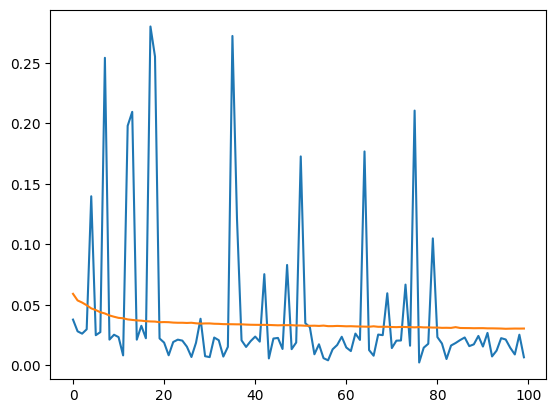

In [30]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [29]:
1

1

### Trained with noise

# Evaluating the model